In [52]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Input
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import time as tm

In [77]:
select_domain  = 1 #0:apnea ro 1:obesity
domain = ['apnea','obesity']
root = '../linkPrediction/'
filepath=[['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv'],
        ['dataset/obesity-all,3.csv',
         'dataset/obesity-distinct_keyword.csv']]
graphpath=root+'graphs/'+domain[select_domain]
datapath=root+'dataframes/'+domain[select_domain]
modelpath=root+'models/'+domain[select_domain]
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_start_year, train_start_year, test_start_year, total_test_period_in_year, total_year_in_each_iteration]
times=[2007,2008,2015,1,1,20]
df, key_list = ut.load_dataset(filepath[select_domain], column_split)

In [78]:
importlib.reload(ut)
train_data = ut.load_data(datapath, domain[select_domain], "train_data", times)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", times)
edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", times)
test_data = ut.load_data(datapath, domain[select_domain], "test_data", times)
test_node = ut.load_data(datapath, domain[select_domain], "test_node", times)
print('train data length:',len(train_data))
print('node feature length:',len(node_feature))
print('edge_list length:',len(edge_list))
print('test_data length:',len(test_data[2015]))
print('test_node length:',len(test_node[2015]))

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
train data length: 7
node feature length: 7
edge_list length: 131006
test_data length: 131006
test_node length: 4038


In [79]:
# time=[1991,1992,1994,1,1,20]
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, times)

../linkPrediction/graphs/obesity\train_graph_2008.gpickle loaded, nodes: 2357 edges: 10285
../linkPrediction/graphs/obesity\train_graph_2009.gpickle loaded, nodes: 2092 edges: 10866
../linkPrediction/graphs/obesity\train_graph_2010.gpickle loaded, nodes: 2301 edges: 12449
../linkPrediction/graphs/obesity\train_graph_2011.gpickle loaded, nodes: 2402 edges: 14811
../linkPrediction/graphs/obesity\train_graph_2012.gpickle loaded, nodes: 2636 edges: 16683
../linkPrediction/graphs/obesity\train_graph_2013.gpickle loaded, nodes: 2635 edges: 16303
../linkPrediction/graphs/obesity\train_graph_2014.gpickle loaded, nodes: 3218 edges: 18244
../linkPrediction/graphs/obesity\test_graph_2015.gpickle loaded, nodes: 4040 edges: 21699
../linkPrediction/graphs/obesity\parent_graph_2007-2008.gpickle loaded, nodes: 2114 edges: 9587
../linkPrediction/graphs/obesity\train_graph_2008-2015.gpickle loaded, nodes: 4040 edges: 66648
../linkPrediction/graphs/obesity\test_graph_2015-2016.gpickle loaded, nodes: 4040

In [80]:
s_key={0:[9875,1020],1:[7614,9953]}
for t in range(2008,2015):
    g_train[t].remove_nodes_from(s_key[select_domain])
g_test[2015].remove_nodes_from(s_key[select_domain])
g_parent.remove_nodes_from(s_key[select_domain])
g_train_static.remove_nodes_from(s_key[select_domain])
g_test_static.remove_nodes_from(s_key[select_domain])

In [81]:
node_feature[2008]

,node_index,y_weight,term_art,term_aut,term_af1,term_af2,term_coun,closeness,degree,citation,degrees,node_type_aut,node_type_art,node_type_deg
0,7943,1,3.563167,3.278160,3.063238,2.763745,3.011017,0.345861,54,861,0.154286,5,5,5
1,9516,1,-0.402686,0.632127,0.203748,0.164155,-0.198249,0.251092,4,47,0.011429,3,3,3
2,1511,1,0.325682,-0.688074,-0.557940,-0.495598,-1.313288,0.266475,5,38,0.014286,5,5,5
3,2459,1,1.994278,1.723824,1.637934,1.417986,1.122538,0.307244,16,113,0.045714,5,5,5
4,4347,1,2.711948,2.788349,2.448573,2.219458,2.465206,0.320385,47,433,0.134286,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350,13338,1,-0.039082,0.160728,-1.139469,-1.153773,-0.868087,0.274018,1,11,0.002857,5,5,5
2351,8056,1,-3.512248,-5.641190,-5.871453,-17.414205,-0.707538,0.000000,0,36,0.000000,1,1,1
2352,2455,1,-3.512248,-0.031978,-0.818661,-1.154218,-0.764235,0.000000,0,9,0.000000,1,1,1
2353,69,1,-3.512248,-0.129811,0.563576,-0.108980,-0.606715,0.000000,0,7,0.000000,1,1,1


In [15]:
def reshape(train_data, node_feature, edge_list, test_data,test_node,times,features):
    ts = times[1]
    te = times[2]+1
    it_index = times[4]
    times_range = te - ts
    total_sample = len(edge_list)
    train_data[times[2]] = test_data
    node_feature[times[2]] = test_node
    feature_length = len(features['edge'])+14
    X = np.zeros([total_sample, times_range, feature_length])
    y = np.zeros(total_sample)
    print("X shape:", X.shape, "y shape:", y.shape)
    for id, edge in enumerate(edge_list):
        for t in range(ts, te, it_index):
            t_data = train_data[t]
            n_data = node_feature[t]
            node_list = set(n_data['node_index'])
            edge_list_t = set(t_data['row_name'])
            if edge in edge_list_t:
                train_row = np.asarray(t_data.loc[t_data['row_name'] == edge,features['edge']].values[0])
                X[id][t - ts][0:6] = train_row
                X[id][t - ts][3] = X[id][t - ts][3]*(t-ts+1)*2
            if edge[0] in node_list:
                node_row0 = np.asarray(n_data.loc[n_data['node_index'] == edge[0],features['node']].values[0])
                X[id][t - ts][6:13] = node_row0
                if edge[1] not in node_list:
                    X[id][t - ts][3] = node_row0[6]*(t-ts+1)
            if edge[1] in node_list:
                node_row1 = np.asarray(n_data.loc[n_data['node_index'] == edge[1],features['node']].values[0])
                X[id][t - ts][13:20] = node_row1
                if edge[0] not in node_list:
                    X[id][t - ts][3] = node_row1[6]*(t-ts+1)
        y[id] = test_data.loc[test_data['row_name'] == edge,'label'].values[0]
    return X, y

In [9]:
features = [{'node':['term_aut','node_type_aut'],
           'edge':['typeaut']},
           {'node':['term_art','node_type_art'],
           'edge':['typeart']},
           {'node':['degree','node_type_deg'],
           'edge':['typenode']},
           {'node':['citation'],
           'edge':['citation1']},
           {'node':['degree'],
           'edge':['pref']},
           {'node':['degree'],
           'edge':['cm']}]

In [8]:
#####################  6           7        8       9              10                11              12
#####################  13          14       15      16             17                18              19
feature = {'node':['term_aut','term_art','degree','node_type_aut','node_type_art','node_type_deg','citation'],
           'edge':['typeaut','typeart','typenode','citation1','pref','cm']}
################       0         1         2           3        4      5

start = tm.time()
X, y = reshape(train_data, node_feature, edge_list, test_data[2015],test_node[2015],times,feature)
end = tm.time()
print(end - start)
ut.save_data(X, datapath, domain[select_domain], "X-features", times)
ut.save_data(y, datapath, domain[select_domain], "y-features", times)

X shape: (12519, 8, 20) y shape: (12519,)
446.3398697376251
../linkPrediction/dataframes/apnea\apnea-X-features_2008-2015.pkl
../linkPrediction/dataframes/apnea\apnea-y-features_2008-2015.pkl


In [39]:
feature_names = {
'author':[0,6,13,9,16],
'article': [1,7,14,10,17],
'degree': [2,8,15,11,18],
'citation': [3,12,19],
'pref': [4,8,15],
'cm': [5,8,15]
}

In [40]:
import keras
import h5py

class CustomSaver(keras.callbacks.Callback):
    
    def __init__(self, param):
        self.name = param[3]
        self.times = param[4]
    def on_epoch_end(self, epoch, logs={}):
        ep_set =set([100,500,1000])
        if epoch in ep_set:  # or save after some epoch, each k-th epoch etc.
            ut.save_data(self.model, datapath, domain[select_domain], "model-"+name+"-"+str(epoch), self.times)
#             filename = domain + "-" + name + "_" + str(time[1]) + "-" + str(time[2]) + ".pkl"
#             filename_path = os.path.join(data_path, filename)
#             self.model.save('mmm.h5')

In [59]:
def create_linear(param):
        inputx = Input(shape=(param[0], param[1]))
        x = LSTM(20)(inputx)
        x = LSTM(20, activation="relu")(inputx)
        x = Dense(40, activation="relu")(x)
        x = Dense(20, activation="relu")(x)
        x = Dense(param[2],activation='linear',name="lin")(x)
        model = Model(inputs=inputx, outputs=x)
        return model

def create_cat1(param):
        inputx = Input(shape=(param[0], param[1]))
        x = LSTM(20)(inputx)
        x = Dense(20)(x)
        x = Dense(10,activation='relu')(x)
        x = Dense(param[2],activation='softmax',name="cat1")(x)
        model = Model(inputs=inputx, outputs=x)
        return model
    
def create_cat2(param):
        inputx = Input(shape=(param[0], param[1]))
        x = LSTM(20)(inputx)
        x = Dense(20)(x)
        x = Dense(10,activation='relu')(x)
        x = Dense(param[2],activation='softmax',name="cat2")(x)
        model = Model(inputs=inputx, outputs=x)
        return model
    
def lstm_forecast(X,param):
        X = ut.scale(X,0,1)
        y = X[:,7]
        X = X[:,0:7]
        batch_size = param[1]
        epoch = param[2]
        names1 = set(['author','article','degree'])
        names2 = set(['citation','pref','cm'])
        print(X.shape,y.shape)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = param[0], random_state = 0)
        ######## the first branch operates on the linear input

        lin_parameters = [X_train.shape[1], X_train.shape[2], y_train.shape[1]]
        lin = create_linear(lin_parameters)        
        
        saver = CustomSaver(param)
        
#         if param[3] in names1:
#             cat_parameters1 = [X_train[:,:,3:7].shape[1], X_train[:,:,3:7].shape[2], y_train[:,3:7].shape[1]]
#             cat1 = create_cat1(cat_parameters1)

#             cat_parameters2 = [X_train[:,:,7:11].shape[1], X_train[:,:,7:11].shape[2], y_train[:,7:11].shape[1]]
#             cat2 = create_cat2(cat_parameters2)
        
#             model = Model(inputs=[lin.input, cat1.input, cat2.input], outputs=[lin.output, cat1.output,cat2.output])
#             model.compile(loss={'lin':'mse','cat1':'categorical_crossentropy','cat2':'categorical_crossentropy'},
#                               optimizer='Adam',
#                               metrics={'lin':'accuracy','cat1':'categorical_accuracy','cat2':'categorical_accuracy'})
#             history = model.fit([X_train[:,:,0:3],X_train[:,:,3:7],X_train[:,:,7:11]],
#                                 [y_train[:,0:3],y_train[:,3:7],y_train[:,7:11]],
#                                 callbacks=[saver],
#                                 batch_size=batch_size,
#                                 epochs=epoch,
#                                 verbose=1)
#         else:
        model = Model(inputs=lin.input, outputs=lin.output)
        model.compile(loss={'lin':'mse'},
                          optimizer='Adam',
                          metrics={'lin':'accuracy'})
        history = model.fit(X_train,
                            y_train,
                            callbacks=[saver],
                            batch_size=batch_size,
                            epochs=epoch,
                            verbose=1)
#         y_pr = model.predict([X_test[:,:,0:3],X_test[:,:,3:7],X_test[:,:,7:11]])
        return X_test, y_test

In [29]:
importlib.reload(ut)
feature_names = {
'author':[0,6,13,9,16],
'article': [1,7,14,10,17],
'degree': [2,8,15,11,18],
'citation': [3,12,19],
'pref': [4,8,15],
'cm': [5,8,15]
}
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
X = ut.load_data(datapath, domain[select_domain], "X-features", times)
y = ut.load_data(datapath, domain[select_domain], "y-features", times)
for name,feature in feature_names.items():
#     if name in names2:
    param = [0.3,64,1001,name,times]
    print(name,"---------------------------------------------------------------------------------")
    X_test, y_test = lstm_forecast(X[:,:,feature],param)
    ut.save_data(X_test, datapath, domain[select_domain], "X_test-"+name, times)
    ut.save_data(y_test, datapath, domain[select_domain], "y_test-"+name, times)

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
author ---------------------------------------------------------------------------------
(130773, 7, 5) (130773, 5)
Epoch 1/1001
91541/91541 [==============================] - 12s 136us/step - loss: 0.0120 - acc: 0.66610s - loss: 0.0121 - acc
Epoch 2/1001
91541/91541 [==============================] - 12s 128us/step - loss: 0.0067 - acc: 0.7066
Epoch 3/1001
91541/91541 [==============================] - 7s 81us/step - loss: 0.0065 - acc: 0.7098
Epoch 4/1001
91541/91541 [==============================] - 7s 78us/step - loss: 0.0063 - acc: 0.7143
Epoch 5/1001
91541/91541 [==============================] - 7s 78us/step - loss: 0.0062 - acc: 0.7178
Epoch 6/1001
91541/91541 [==============================] - 7s 80us/step - loss: 0.0062 - acc: 0.7192
Epoch 7/1001
91541/91541 [==============================] - 8s 90us/step - loss: 0.0061 - acc: 0.7217
Epoch 8/1001
91541/91541 [==============================] - 8s 92us/s

91541/91541 [==============================] - 7s 78us/step - loss: 0.0050 - acc: 0.7483
Epoch 155/1001
91541/91541 [==============================] - 8s 89us/step - loss: 0.0050 - acc: 0.7488
Epoch 156/1001
91541/91541 [==============================] - 9s 97us/step - loss: 0.0050 - acc: 0.7471
Epoch 157/1001
91541/91541 [==============================] - 8s 86us/step - loss: 0.0050 - acc: 0.7485
Epoch 158/1001
91541/91541 [==============================] - 9s 99us/step - loss: 0.0050 - acc: 0.7470
Epoch 159/1001
91541/91541 [==============================] - 10s 110us/step - loss: 0.0050 - acc: 0.74800s - loss: 0.0050 - acc: 0.748 - ETA: 0s - loss: 0.005
Epoch 160/1001
91541/91541 [==============================] - 8s 85us/step - loss: 0.0050 - acc: 0.7494
Epoch 161/1001
91541/91541 [==============================] - 8s 91us/step - loss: 0.0050 - acc: 0.7488
Epoch 162/1001
91541/91541 [==============================] - 8s 92us/step - loss: 0.0050 - acc: 0.7479
Epoch 163/1001
91541/91

91541/91541 [==============================] - 6s 70us/step - loss: 0.0045 - acc: 0.7544
Epoch 308/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0045 - acc: 0.7561
Epoch 309/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0045 - acc: 0.7553
Epoch 310/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0045 - acc: 0.7548
Epoch 311/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0045 - acc: 0.7548
Epoch 312/1001
91541/91541 [==============================] - ETA: 0s - loss: 0.0045 - acc: 0.753 - 6s 66us/step - loss: 0.0045 - acc: 0.7530
Epoch 313/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0045 - acc: 0.7538
Epoch 314/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0045 - acc: 0.7554
Epoch 315/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0045 - acc: 0.7554
Epoch 316/1001
91541/91541 [=============

91541/91541 [==============================] - 6s 67us/step - loss: 0.0043 - acc: 0.7590
Epoch 464/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0043 - acc: 0.7579
Epoch 465/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0043 - acc: 0.7591
Epoch 466/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0043 - acc: 0.7593
Epoch 467/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0043 - acc: 0.7593
Epoch 468/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0043 - acc: 0.7590
Epoch 469/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0043 - acc: 0.7585
Epoch 470/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0043 - acc: 0.7601
Epoch 471/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0043 - acc: 0.7596
Epoch 472/1001
91541/91541 [==============================] - 6s 68us/step - lo

91541/91541 [==============================] - 6s 67us/step - loss: 0.0042 - acc: 0.7626
Epoch 620/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0042 - acc: 0.7634
Epoch 621/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0042 - acc: 0.7620
Epoch 622/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0042 - acc: 0.7620
Epoch 623/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0042 - acc: 0.7620
Epoch 624/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0042 - acc: 0.7625
Epoch 625/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0042 - acc: 0.7625
Epoch 626/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0042 - acc: 0.7623
Epoch 627/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0042 - acc: 0.7618
Epoch 628/1001
91541/91541 [==============================] - 6s 67us/step - lo

91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7641
Epoch 776/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7632
Epoch 777/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0041 - acc: 0.7639
Epoch 778/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7635
Epoch 779/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0041 - acc: 0.7641
Epoch 780/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0041 - acc: 0.7639
Epoch 781/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0041 - acc: 0.7642
Epoch 782/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7629
Epoch 783/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7640
Epoch 784/1001
91541/91541 [==============================] - 6s 64us/step - lo

91541/91541 [==============================] - 6s 67us/step - loss: 0.0041 - acc: 0.7633
Epoch 932/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0041 - acc: 0.7642
Epoch 933/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7647
Epoch 934/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7637
Epoch 935/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7630
Epoch 936/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7651
Epoch 937/1001
91541/91541 [==============================] - ETA: 0s - loss: 0.0041 - acc: 0.764 - 6s 64us/step - loss: 0.0041 - acc: 0.7641
Epoch 938/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7634
Epoch 939/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0041 - acc: 0.7637
Epoch 940/1001
91541/91541 [=============

91541/91541 [==============================] - 6s 65us/step - loss: 0.0063 - acc: 0.7523
Epoch 84/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0063 - acc: 0.7520
Epoch 85/1001
91541/91541 [==============================] - 6s 63us/step - loss: 0.0063 - acc: 0.7511
Epoch 86/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0063 - acc: 0.7521
Epoch 87/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0063 - acc: 0.7523
Epoch 88/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0063 - acc: 0.7523
Epoch 89/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0063 - acc: 0.7525
Epoch 90/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0063 - acc: 0.7519
Epoch 91/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0063 - acc: 0.7544
Epoch 92/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.006

91541/91541 [==============================] - 6s 65us/step - loss: 0.0057 - acc: 0.7650
Epoch 240/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0057 - acc: 0.7640
Epoch 241/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0058 - acc: 0.7658
Epoch 242/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0057 - acc: 0.7657
Epoch 243/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0057 - acc: 0.7649
Epoch 244/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0057 - acc: 0.7640
Epoch 245/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0057 - acc: 0.7655
Epoch 246/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0057 - acc: 0.7653
Epoch 247/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0057 - acc: 0.7654
Epoch 248/1001
91541/91541 [==============================] - 6s 67us/step - lo

91541/91541 [==============================] - 6s 65us/step - loss: 0.0055 - acc: 0.7725
Epoch 396/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0055 - acc: 0.7730
Epoch 397/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0055 - acc: 0.7726
Epoch 398/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0054 - acc: 0.7722
Epoch 399/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0054 - acc: 0.7726
Epoch 400/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0054 - acc: 0.7716
Epoch 401/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0054 - acc: 0.7724
Epoch 402/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0055 - acc: 0.7725
Epoch 403/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0054 - acc: 0.7719
Epoch 404/1001
91541/91541 [==============================] - 6s 65us/step - lo

91541/91541 [==============================] - 6s 65us/step - loss: 0.0053 - acc: 0.7740
Epoch 551/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0053 - acc: 0.7758
Epoch 552/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0053 - acc: 0.7736
Epoch 553/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0053 - acc: 0.7745
Epoch 554/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0053 - acc: 0.7732
Epoch 555/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0053 - acc: 0.7732
Epoch 556/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0053 - acc: 0.7742
Epoch 557/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0053 - acc: 0.7742
Epoch 558/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0053 - acc: 0.7730
Epoch 559/1001
91541/91541 [==============================] - 6s 65us/step - lo

91541/91541 [==============================] - 6s 64us/step - loss: 0.0052 - acc: 0.7757
Epoch 707/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0052 - acc: 0.7765
Epoch 708/1001
91541/91541 [==============================] - 6s 70us/step - loss: 0.0052 - acc: 0.7765
Epoch 709/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0052 - acc: 0.7764
Epoch 710/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0052 - acc: 0.7772
Epoch 711/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0052 - acc: 0.7769
Epoch 712/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0051 - acc: 0.7770
Epoch 713/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0052 - acc: 0.7760
Epoch 714/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0052 - acc: 0.7767
Epoch 715/1001
91541/91541 [==============================] - 6s 66us/step - lo

91541/91541 [==============================] - 6s 69us/step - loss: 0.0051 - acc: 0.7787
Epoch 862/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0051 - acc: 0.7770
Epoch 863/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0051 - acc: 0.7773
Epoch 864/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0051 - acc: 0.7773
Epoch 865/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0051 - acc: 0.7787
Epoch 866/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0051 - acc: 0.7778
Epoch 867/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0051 - acc: 0.7787
Epoch 868/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0051 - acc: 0.7769
Epoch 869/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0051 - acc: 0.7774
Epoch 870/1001
91541/91541 [==============================] - 6s 65us/step - lo

91541/91541 [==============================] - 6s 69us/step - loss: 0.0027 - acc: 0.6947
Epoch 14/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0027 - acc: 0.6947
Epoch 15/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0027 - acc: 0.6949
Epoch 16/1001
91541/91541 [==============================] - 6s 63us/step - loss: 0.0027 - acc: 0.6948
Epoch 17/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0027 - acc: 0.6954
Epoch 18/1001
91541/91541 [==============================] - 6s 63us/step - loss: 0.0027 - acc: 0.6943
Epoch 19/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0027 - acc: 0.6950
Epoch 20/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0027 - acc: 0.6939
Epoch 21/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0027 - acc: 0.6949
Epoch 22/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.002

Epoch 92/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0024 - acc: 0.7059
Epoch 93/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0024 - acc: 0.7070
Epoch 94/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0024 - acc: 0.7070
Epoch 95/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0024 - acc: 0.7055
Epoch 96/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0024 - acc: 0.7062
Epoch 97/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0024 - acc: 0.7095
Epoch 98/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0023 - acc: 0.7076
Epoch 99/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0023 - acc: 0.7078
Epoch 100/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0023 - acc: 0.7080
Epoch 101/1001
91541/91541 [==============================] - 6s 64us/st

91541/91541 [==============================] - 6s 66us/step - loss: 0.0021 - acc: 0.7234
Epoch 248/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0021 - acc: 0.7244
Epoch 249/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0021 - acc: 0.7233
Epoch 250/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0021 - acc: 0.7225
Epoch 251/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0020 - acc: 0.7234
Epoch 252/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0020 - acc: 0.7237
Epoch 253/1001
91541/91541 [==============================] - 6s 68us/step - loss: 0.0021 - acc: 0.7238
Epoch 254/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0020 - acc: 0.7236
Epoch 255/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0020 - acc: 0.7234
Epoch 256/1001
91541/91541 [==============================] - 6s 65us/step - lo

91541/91541 [==============================] - 6s 65us/step - loss: 0.0019 - acc: 0.7332
Epoch 404/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0019 - acc: 0.7323
Epoch 405/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0019 - acc: 0.7331
Epoch 406/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0019 - acc: 0.7326
Epoch 407/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0019 - acc: 0.7340
Epoch 408/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0019 - acc: 0.7337
Epoch 409/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0019 - acc: 0.7333
Epoch 410/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0019 - acc: 0.7321
Epoch 411/1001
91541/91541 [==============================] - 6s 67us/step - loss: 0.0019 - acc: 0.7342
Epoch 412/1001
91541/91541 [==============================] - 6s 65us/step - lo

91541/91541 [==============================] - 6s 66us/step - loss: 0.0019 - acc: 0.7387
Epoch 559/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0018 - acc: 0.7385
Epoch 560/1001
91541/91541 [==============================] - 6s 70us/step - loss: 0.0019 - acc: 0.7382
Epoch 561/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0019 - acc: 0.7387
Epoch 562/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0019 - acc: 0.7393
Epoch 563/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0019 - acc: 0.7383
Epoch 564/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7401
Epoch 565/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0019 - acc: 0.7384
Epoch 566/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0019 - acc: 0.7386
Epoch 567/1001
91541/91541 [==============================] - 6s 65us/step - lo

91541/91541 [==============================] - 6s 66us/step - loss: 0.0018 - acc: 0.7415
Epoch 715/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7418
Epoch 716/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7408
Epoch 717/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0018 - acc: 0.7421
Epoch 718/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7419
Epoch 719/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0018 - acc: 0.7421
Epoch 720/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0018 - acc: 0.7411
Epoch 721/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7408
Epoch 722/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0018 - acc: 0.7423
Epoch 723/1001
91541/91541 [==============================] - 6s 65us/step - lo

91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7435
Epoch 871/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7447
Epoch 872/1001
91541/91541 [==============================] - 6s 64us/step - loss: 0.0018 - acc: 0.7435
Epoch 873/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0018 - acc: 0.7439
Epoch 874/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7440
Epoch 875/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7435
Epoch 876/1001
91541/91541 [==============================] - 6s 65us/step - loss: 0.0018 - acc: 0.7445
Epoch 877/1001
91541/91541 [==============================] - 6s 69us/step - loss: 0.0018 - acc: 0.7453
Epoch 878/1001
91541/91541 [==============================] - 6s 66us/step - loss: 0.0018 - acc: 0.7438
Epoch 879/1001
91541/91541 [==============================] - 6s 65us/step - lo

91541/91541 [==============================] - 5s 53us/step - loss: 3.4942e-05 - acc: 0.9998
Epoch 22/1001
91541/91541 [==============================] - 5s 51us/step - loss: 3.5212e-05 - acc: 0.9996
Epoch 23/1001
91541/91541 [==============================] - 5s 51us/step - loss: 3.4353e-05 - acc: 0.9998
Epoch 24/1001
91541/91541 [==============================] - 5s 52us/step - loss: 3.4422e-05 - acc: 0.9992
Epoch 25/1001
91541/91541 [==============================] - 5s 51us/step - loss: 3.3437e-05 - acc: 0.9995
Epoch 26/1001
91541/91541 [==============================] - 5s 51us/step - loss: 3.2980e-05 - acc: 0.9991
Epoch 27/1001
91541/91541 [==============================] - 5s 52us/step - loss: 3.3183e-05 - acc: 0.9996
Epoch 28/1001
91541/91541 [==============================] - 5s 52us/step - loss: 3.2196e-05 - acc: 0.9997
Epoch 29/1001
91541/91541 [==============================] - 5s 52us/step - loss: 3.2104e-05 - acc: 0.9995
Epoch 30/1001
91541/91541 [========================

91541/91541 [==============================] - 6s 69us/step - loss: 2.2086e-05 - acc: 0.9997
Epoch 171/1001
91541/91541 [==============================] - 6s 65us/step - loss: 2.2429e-05 - acc: 0.9990
Epoch 172/1001
91541/91541 [==============================] - 6s 63us/step - loss: 2.2160e-05 - acc: 0.9997
Epoch 173/1001
91541/91541 [==============================] - 6s 64us/step - loss: 2.2192e-05 - acc: 0.9996
Epoch 174/1001
91541/91541 [==============================] - 6s 66us/step - loss: 2.2183e-05 - acc: 0.9998
Epoch 175/1001
91541/91541 [==============================] - 6s 65us/step - loss: 2.2133e-05 - acc: 0.9997
Epoch 176/1001
91541/91541 [==============================] - 6s 64us/step - loss: 2.2012e-05 - acc: 0.9997
Epoch 177/1001
91541/91541 [==============================] - 6s 65us/step - loss: 2.1990e-05 - acc: 0.9996
Epoch 178/1001
91541/91541 [==============================] - 6s 64us/step - loss: 2.2113e-05 - acc: 0.9995
Epoch 179/1001
91541/91541 [===============

Epoch 321/1001
91541/91541 [==============================] - 6s 64us/step - loss: 2.0007e-05 - acc: 0.9998
Epoch 322/1001
91541/91541 [==============================] - 6s 65us/step - loss: 1.9804e-05 - acc: 0.9997
Epoch 323/1001
91541/91541 [==============================] - 6s 64us/step - loss: 1.9854e-05 - acc: 0.9999
Epoch 324/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.9623e-05 - acc: 0.9996
Epoch 325/1001
91541/91541 [==============================] - 6s 68us/step - loss: 1.9773e-05 - acc: 0.9995
Epoch 326/1001
91541/91541 [==============================] - 6s 65us/step - loss: 1.9642e-05 - acc: 0.9997
Epoch 327/1001
91541/91541 [==============================] - 6s 64us/step - loss: 1.9870e-05 - acc: 0.9999
Epoch 328/1001
91541/91541 [==============================] - 6s 64us/step - loss: 1.9658e-05 - acc: 0.9998
Epoch 329/1001
91541/91541 [==============================] - 6s 64us/step - loss: 1.9756e-05 - acc: 0.9993
Epoch 330/1001
91541/91541 [

91541/91541 [==============================] - 6s 64us/step - loss: 1.9136e-05 - acc: 0.9995
Epoch 397/1001
91541/91541 [==============================] - 6s 64us/step - loss: 1.9223e-05 - acc: 0.9992
Epoch 398/1001
91541/91541 [==============================] - 6s 64us/step - loss: 1.9247e-05 - acc: 0.9998
Epoch 399/1001
91541/91541 [==============================] - 6s 64us/step - loss: 1.9113e-05 - acc: 0.9997
Epoch 400/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.9333e-05 - acc: 0.9999
Epoch 401/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.9013e-05 - acc: 0.9998
Epoch 402/1001
91541/91541 [==============================] - 6s 67us/step - loss: 1.9033e-05 - acc: 0.9998
Epoch 403/1001
91541/91541 [==============================] - 6s 65us/step - loss: 1.9107e-05 - acc: 0.9998
Epoch 404/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.9109e-05 - acc: 0.9998
Epoch 405/1001
91541/91541 [===============

91541/91541 [==============================] - 7s 73us/step - loss: 1.8383e-05 - acc: 0.9998
Epoch 547/1001
91541/91541 [==============================] - 7s 72us/step - loss: 1.8379e-05 - acc: 0.9997
Epoch 548/1001
91541/91541 [==============================] - 6s 71us/step - loss: 1.8309e-05 - acc: 0.9995
Epoch 549/1001
91541/91541 [==============================] - 7s 74us/step - loss: 1.8287e-05 - acc: 0.9997
Epoch 550/1001
91541/91541 [==============================] - 7s 73us/step - loss: 1.8262e-05 - acc: 0.9996
Epoch 551/1001
91541/91541 [==============================] - 7s 71us/step - loss: 1.8400e-05 - acc: 0.9996
Epoch 552/1001
91541/91541 [==============================] - 7s 71us/step - loss: 1.8281e-05 - acc: 0.9995
Epoch 553/1001
91541/91541 [==============================] - 7s 71us/step - loss: 1.8432e-05 - acc: 0.9996
Epoch 554/1001
91541/91541 [==============================] - 7s 71us/step - loss: 1.8364e-05 - acc: 0.9995
Epoch 555/1001
91541/91541 [===============

Epoch 697/1001
91541/91541 [==============================] - 6s 68us/step - loss: 1.7992e-05 - acc: 0.9995
Epoch 698/1001
91541/91541 [==============================] - 6s 68us/step - loss: 1.7642e-05 - acc: 0.9994
Epoch 699/1001
91541/91541 [==============================] - 6s 68us/step - loss: 1.7727e-05 - acc: 0.9996
Epoch 700/1001
91541/91541 [==============================] - 6s 68us/step - loss: 1.7820e-05 - acc: 0.9995
Epoch 701/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.7594e-05 - acc: 0.9996
Epoch 702/1001
91541/91541 [==============================] - 6s 69us/step - loss: 1.7693e-05 - acc: 0.9995
Epoch 703/1001
91541/91541 [==============================] - 6s 68us/step - loss: 1.7635e-05 - acc: 0.9996
Epoch 704/1001
91541/91541 [==============================] - 6s 68us/step - loss: 1.7798e-05 - acc: 0.9994
Epoch 705/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.7617e-05 - acc: 0.9996
Epoch 706/1001
91541/91541 [

91541/91541 [==============================] - 6s 70us/step - loss: 1.7265e-05 - acc: 0.9992
Epoch 848/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.7225e-05 - acc: 0.9992
Epoch 849/1001
91541/91541 [==============================] - 6s 69us/step - loss: 1.7257e-05 - acc: 0.9992
Epoch 850/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.7166e-05 - acc: 0.9990
Epoch 851/1001
91541/91541 [==============================] - 7s 72us/step - loss: 1.7130e-05 - acc: 0.9992
Epoch 852/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.7176e-05 - acc: 0.9992
Epoch 853/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.7100e-05 - acc: 0.9994
Epoch 854/1001
91541/91541 [==============================] - 6s 69us/step - loss: 1.7232e-05 - acc: 0.9994
Epoch 855/1001
91541/91541 [==============================] - 7s 72us/step - loss: 1.7233e-05 - acc: 0.9993
Epoch 856/1001
91541/91541 [===============

91541/91541 [==============================] - 6s 70us/step - loss: 1.6803e-05 - acc: 0.9990
Epoch 998/1001
91541/91541 [==============================] - 7s 74us/step - loss: 1.6841e-05 - acc: 0.9990
Epoch 999/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.6845e-05 - acc: 0.9991
Epoch 1000/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.6828e-05 - acc: 0.9990
Epoch 1001/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.6872e-05 - acc: 0.9992
../linkPrediction/dataframes/obesity\obesity-model-citation-1000_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-X_test-citation_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-y_test-citation_2008-2015.pkl
pref ---------------------------------------------------------------------------------
(130773, 7, 3) (130773, 3)
Epoch 1/1001
91541/91541 [==============================] - 6s 64us/step - loss: 4.8516e-04 - acc: 0.6990
Epoch 2/1001
91541/91541

91541/91541 [==============================] - 6s 65us/step - loss: 1.2018e-04 - acc: 0.7306: 0s - loss: 1.2054e-04 - a
Epoch 145/1001
91541/91541 [==============================] - 6s 65us/step - loss: 1.1829e-04 - acc: 0.7319
Epoch 146/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.1787e-04 - acc: 0.7325
Epoch 147/1001
91541/91541 [==============================] - 6s 65us/step - loss: 1.1843e-04 - acc: 0.7314
Epoch 148/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.1735e-04 - acc: 0.7312
Epoch 149/1001
91541/91541 [==============================] - 7s 81us/step - loss: 1.1740e-04 - acc: 0.7323
Epoch 150/1001
91541/91541 [==============================] - 6s 70us/step - loss: 1.1794e-04 - acc: 0.7317
Epoch 151/1001
91541/91541 [==============================] - 6s 69us/step - loss: 1.1697e-04 - acc: 0.7309
Epoch 152/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.1692e-04 - acc: 0.7322
Epoch 153/1001
9

91541/91541 [==============================] - 6s 66us/step - loss: 1.0373e-04 - acc: 0.7348
Epoch 295/1001
91541/91541 [==============================] - 6s 65us/step - loss: 1.0230e-04 - acc: 0.7332
Epoch 296/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.0241e-04 - acc: 0.7346
Epoch 297/1001
91541/91541 [==============================] - 6s 65us/step - loss: 1.0299e-04 - acc: 0.7353
Epoch 298/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.0314e-04 - acc: 0.7331
Epoch 299/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.0236e-04 - acc: 0.7340
Epoch 300/1001
91541/91541 [==============================] - 6s 66us/step - loss: 1.0254e-04 - acc: 0.7341
Epoch 301/1001
91541/91541 [==============================] - 6s 67us/step - loss: 1.0319e-04 - acc: 0.7323
Epoch 302/1001
91541/91541 [==============================] - 7s 71us/step - loss: 1.0186e-04 - acc: 0.7330
Epoch 303/1001
91541/91541 [===============

91541/91541 [==============================] - 6s 66us/step - loss: 9.3660e-05 - acc: 0.7352
Epoch 445/1001
91541/91541 [==============================] - 6s 66us/step - loss: 9.4861e-05 - acc: 0.7333
Epoch 446/1001
91541/91541 [==============================] - 6s 66us/step - loss: 9.3309e-05 - acc: 0.7342
Epoch 447/1001
91541/91541 [==============================] - 6s 67us/step - loss: 9.3865e-05 - acc: 0.7352
Epoch 448/1001
91541/91541 [==============================] - 6s 66us/step - loss: 9.3359e-05 - acc: 0.7352
Epoch 449/1001
91541/91541 [==============================] - 6s 65us/step - loss: 9.4286e-05 - acc: 0.7350
Epoch 450/1001
91541/91541 [==============================] - 6s 66us/step - loss: 9.4105e-05 - acc: 0.7339
Epoch 451/1001
91541/91541 [==============================] - 6s 65us/step - loss: 9.3688e-05 - acc: 0.7335
Epoch 452/1001
91541/91541 [==============================] - 6s 67us/step - loss: 9.3808e-05 - acc: 0.7336
Epoch 453/1001
91541/91541 [===============

91541/91541 [==============================] - 7s 82us/step - loss: 8.9031e-05 - acc: 0.7338
Epoch 594/1001
91541/91541 [==============================] - 12s 133us/step - loss: 8.9372e-05 - acc: 0.7346
Epoch 595/1001
91541/91541 [==============================] - 8s 89us/step - loss: 8.8963e-05 - acc: 0.7353
Epoch 596/1001
91541/91541 [==============================] - 9s 93us/step - loss: 8.9914e-05 - acc: 0.7350
Epoch 597/1001
91541/91541 [==============================] - 8s 82us/step - loss: 8.8967e-05 - acc: 0.7349
Epoch 598/1001
91541/91541 [==============================] - 11s 120us/step - loss: 8.9414e-05 - acc: 0.7357
Epoch 599/1001
91541/91541 [==============================] - 8s 82us/step - loss: 8.9259e-05 - acc: 0.7345
Epoch 600/1001
91541/91541 [==============================] - 7s 82us/step - loss: 8.9413e-05 - acc: 0.7348
Epoch 601/1001
91541/91541 [==============================] - 9s 99us/step - loss: 8.9765e-05 - acc: 0.7333
Epoch 602/1001
91541/91541 [===========

91541/91541 [==============================] - 6s 68us/step - loss: 8.6797e-05 - acc: 0.7350
Epoch 743/1001
91541/91541 [==============================] - 6s 67us/step - loss: 8.7070e-05 - acc: 0.7348
Epoch 744/1001
91541/91541 [==============================] - 6s 67us/step - loss: 8.7033e-05 - acc: 0.7354
Epoch 745/1001
91541/91541 [==============================] - 6s 67us/step - loss: 8.7607e-05 - acc: 0.7347
Epoch 746/1001
91541/91541 [==============================] - 6s 68us/step - loss: 8.6581e-05 - acc: 0.7353
Epoch 747/1001
91541/91541 [==============================] - 7s 71us/step - loss: 8.7916e-05 - acc: 0.7361
Epoch 748/1001
91541/91541 [==============================] - 6s 68us/step - loss: 8.6811e-05 - acc: 0.7347
Epoch 749/1001
91541/91541 [==============================] - 7s 79us/step - loss: 8.6469e-05 - acc: 0.7351
Epoch 750/1001
91541/91541 [==============================] - 6s 70us/step - loss: 8.7185e-05 - acc: 0.7343
Epoch 751/1001
91541/91541 [===============

91541/91541 [==============================] - 8s 91us/step - loss: 8.5382e-05 - acc: 0.7355: 0s - loss: 8.5188e-05 - acc: 0.7 - ETA: 0s - loss: 8.5463e-05 - acc: 0.7 - ETA: 0s - loss: 8.5467e-05 - acc: 
Epoch 893/1001
91541/91541 [==============================] - 10s 108us/step - loss: 8.5277e-05 - acc: 0.7350
Epoch 894/1001
91541/91541 [==============================] - 8s 93us/step - loss: 8.5420e-05 - acc: 0.7351
Epoch 895/1001
91541/91541 [==============================] - 7s 72us/step - loss: 8.5165e-05 - acc: 0.7365
Epoch 896/1001
91541/91541 [==============================] - 7s 77us/step - loss: 8.5928e-05 - acc: 0.7364
Epoch 897/1001
91541/91541 [==============================] - 7s 72us/step - loss: 8.4710e-05 - acc: 0.7355
Epoch 898/1001
91541/91541 [==============================] - 7s 75us/step - loss: 8.4739e-05 - acc: 0.7355
Epoch 899/1001
91541/91541 [==============================] - 9s 102us/step - loss: 8.5352e-05 - acc: 0.7367
Epoch 900/1001
91541/91541 [=========

91541/91541 [==============================] - 6s 69us/step - loss: 3.1622e-04 - acc: 0.6806
Epoch 38/1001
91541/91541 [==============================] - 6s 69us/step - loss: 3.1525e-04 - acc: 0.6822
Epoch 39/1001
91541/91541 [==============================] - 7s 81us/step - loss: 3.1421e-04 - acc: 0.6819
Epoch 40/1001
91541/91541 [==============================] - 8s 86us/step - loss: 3.1369e-04 - acc: 0.6831
Epoch 41/1001
91541/91541 [==============================] - 7s 71us/step - loss: 3.1305e-04 - acc: 0.6831
Epoch 42/1001
91541/91541 [==============================] - 8s 82us/step - loss: 3.1279e-04 - acc: 0.6822
Epoch 43/1001
91541/91541 [==============================] - 9s 102us/step - loss: 3.1142e-04 - acc: 0.6795
Epoch 44/1001
91541/91541 [==============================] - 8s 88us/step - loss: 3.0994e-04 - acc: 0.6847
Epoch 45/1001
91541/91541 [==============================] - 7s 73us/step - loss: 3.1146e-04 - acc: 0.6808
Epoch 46/1001
91541/91541 [=======================

91541/91541 [==============================] - 6s 69us/step - loss: 2.7008e-04 - acc: 0.6846
Epoch 188/1001
91541/91541 [==============================] - 6s 71us/step - loss: 2.6881e-04 - acc: 0.6859
Epoch 189/1001
91541/91541 [==============================] - 6s 70us/step - loss: 2.6904e-04 - acc: 0.6861
Epoch 190/1001
91541/91541 [==============================] - 6s 71us/step - loss: 2.6894e-04 - acc: 0.6867
Epoch 191/1001
91541/91541 [==============================] - 7s 76us/step - loss: 2.6842e-04 - acc: 0.6856
Epoch 192/1001
91541/91541 [==============================] - 7s 75us/step - loss: 2.6932e-04 - acc: 0.6850
Epoch 193/1001
91541/91541 [==============================] - 7s 73us/step - loss: 2.6875e-04 - acc: 0.6864
Epoch 194/1001
91541/91541 [==============================] - 6s 70us/step - loss: 2.6911e-04 - acc: 0.6861
Epoch 195/1001
91541/91541 [==============================] - 6s 70us/step - loss: 2.6790e-04 - acc: 0.6874
Epoch 196/1001
91541/91541 [===============

Epoch 263/1001
91541/91541 [==============================] - 6s 70us/step - loss: 2.6010e-04 - acc: 0.6889
Epoch 264/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.5926e-04 - acc: 0.6886
Epoch 265/1001
91541/91541 [==============================] - 6s 67us/step - loss: 2.5986e-04 - acc: 0.6890
Epoch 266/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.6018e-04 - acc: 0.6867
Epoch 267/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.5853e-04 - acc: 0.6898
Epoch 268/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.5802e-04 - acc: 0.6898
Epoch 269/1001
91541/91541 [==============================] - 6s 67us/step - loss: 2.5867e-04 - acc: 0.6879
Epoch 270/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.5879e-04 - acc: 0.6879
Epoch 271/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.5775e-04 - acc: 0.6878
Epoch 272/1001
91541/91541 [

Epoch 414/1001
91541/91541 [==============================] - 7s 74us/step - loss: 2.5016e-04 - acc: 0.6894
Epoch 415/1001
91541/91541 [==============================] - 7s 73us/step - loss: 2.5101e-04 - acc: 0.6908
Epoch 416/1001
91541/91541 [==============================] - 7s 72us/step - loss: 2.5044e-04 - acc: 0.6900
Epoch 417/1001
91541/91541 [==============================] - 7s 72us/step - loss: 2.5029e-04 - acc: 0.6889
Epoch 418/1001
91541/91541 [==============================] - 7s 72us/step - loss: 2.5003e-04 - acc: 0.6899
Epoch 419/1001
91541/91541 [==============================] - 7s 72us/step - loss: 2.5116e-04 - acc: 0.6891
Epoch 420/1001
91541/91541 [==============================] - 7s 72us/step - loss: 2.5066e-04 - acc: 0.6911
Epoch 421/1001
91541/91541 [==============================] - 7s 73us/step - loss: 2.4988e-04 - acc: 0.6899
Epoch 422/1001
91541/91541 [==============================] - 7s 71us/step - loss: 2.5078e-04 - acc: 0.6877
Epoch 423/1001
91541/91541 [

91541/91541 [==============================] - 6s 68us/step - loss: 2.4477e-04 - acc: 0.6902
Epoch 565/1001
91541/91541 [==============================] - 7s 72us/step - loss: 2.4577e-04 - acc: 0.6914: 0s - loss: 2.4625e-04 - acc: 0.6
Epoch 566/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.4522e-04 - acc: 0.6907
Epoch 567/1001
91541/91541 [==============================] - 6s 69us/step - loss: 2.4513e-04 - acc: 0.6880
Epoch 568/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.4396e-04 - acc: 0.6919
Epoch 569/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.4493e-04 - acc: 0.6910
Epoch 570/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.4430e-04 - acc: 0.6905
Epoch 571/1001
91541/91541 [==============================] - 7s 71us/step - loss: 2.4523e-04 - acc: 0.6892
Epoch 572/1001
91541/91541 [==============================] - 6s 69us/step - loss: 2.4481e-04 - acc: 0.6923: 1s - los

Epoch 715/1001
91541/91541 [==============================] - 6s 69us/step - loss: 2.4187e-04 - acc: 0.6911
Epoch 716/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.4120e-04 - acc: 0.6916
Epoch 717/1001
91541/91541 [==============================] - 6s 69us/step - loss: 2.4111e-04 - acc: 0.6901
Epoch 718/1001
91541/91541 [==============================] - 6s 69us/step - loss: 2.4067e-04 - acc: 0.6923
Epoch 719/1001
91541/91541 [==============================] - 7s 72us/step - loss: 2.4177e-04 - acc: 0.6911
Epoch 720/1001
91541/91541 [==============================] - 6s 70us/step - loss: 2.4083e-04 - acc: 0.6900
Epoch 721/1001
91541/91541 [==============================] - 6s 69us/step - loss: 2.4258e-04 - acc: 0.6904
Epoch 722/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.4143e-04 - acc: 0.6909
Epoch 723/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.4154e-04 - acc: 0.6913
Epoch 724/1001
91541/91541 [

91541/91541 [==============================] - 6s 68us/step - loss: 2.3862e-04 - acc: 0.6912
Epoch 866/1001
91541/91541 [==============================] - 6s 66us/step - loss: 2.3899e-04 - acc: 0.6930
Epoch 867/1001
91541/91541 [==============================] - 6s 66us/step - loss: 2.3916e-04 - acc: 0.6920
Epoch 868/1001
91541/91541 [==============================] - 6s 71us/step - loss: 2.3862e-04 - acc: 0.6913
Epoch 869/1001
91541/91541 [==============================] - 6s 69us/step - loss: 2.3843e-04 - acc: 0.6901
Epoch 870/1001
91541/91541 [==============================] - 6s 66us/step - loss: 2.3849e-04 - acc: 0.6912
Epoch 871/1001
91541/91541 [==============================] - 6s 67us/step - loss: 2.3842e-04 - acc: 0.6909
Epoch 872/1001
91541/91541 [==============================] - 6s 68us/step - loss: 2.3871e-04 - acc: 0.6905
Epoch 873/1001
91541/91541 [==============================] - 7s 80us/step - loss: 2.3819e-04 - acc: 0.6918
Epoch 874/1001
91541/91541 [===============

In [95]:

a=np.argmax(y_pr[2], axis=1) 

In [83]:
X_test.shape

(39302, 7, 11)

In [73]:
m=ut.load_data(datapath, domain[select_domain], "model-author-100", times)

../linkPrediction/dataframes/apnea


In [84]:
X_test = ut.load_data(datapath, domain[select_domain], "X_test-"+"author", times)
y_test = ut.load_data(datapath, domain[select_domain], "y_test-"+"author", times)
y_pr = m.predict(X_test)

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 1 arrays: [array([[[0.00000000e+00, 7.81896360e-01, 6.36857377e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.91465763e-03, 7.49642280e-01, 6.40413071e-01, ...,
         1.000000...

In [65]:
feature_names = {
'author':[0,6,13,9,16]
# 'article': [1,7,14,10,17],
# 'degree': [2,8,15,11,18],
# 'citation': [3,12,19],
# 'pref': [4,8,15],
# 'cm': [5,8,15]
}
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
epochs = [100,500,1000]
for name,feature in feature_names.items():
    X_test = ut.load_data(datapath, domain[select_domain], "X_test-"+name, times)
    y_test = ut.load_data(datapath, domain[select_domain], "y_test-"+name, times)
    for ep in epochs:      
#         if name in names1:
#             m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(ep), times)    
#             y_pr = m.predict([X_test[:,:,0:3],X_test[:,:,3:7],X_test[:,:,7:11]])
#             mse = mean_squared_error(y_test[:,0],y_pr[0][:,0])
#             rmse1 = sqrt(mse)
#             mse = mean_squared_error(y_test[:,1],y_pr[0][:,1])
#             rmse2 = sqrt(mse)
#             print(name,"-",ep,":",rmse1," --- ",rmse2)
#         if name in names2:
        m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(ep), times)
        y_pr = m.predict(X_test)
        mse = mean_squared_error(y_test[:,0],y_pr[:,0])
        rmse1 = sqrt(mse)
        mse = mean_squared_error(y_test[:,1],y_pr[:,1])
        rmse2 = sqrt(mse)
        print(name,"-",ep,":",rmse1," --- ",rmse2)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 1 arrays: [array([[[1.87793427e-03, 5.05892070e-01, 4.79352501e-01, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [9.38967136e-04, 3.02766091e-01, 2.34241006e-01, ...,
         0.000000...

In [19]:
feature_names = {
'author':[0,6,13,9,16],
'article': [1,7,14,10,17],
'degree': [2,8,15,11,18],
'citation': [3,12,19],
'pref': [4,8,15],
'cm': [5,8,15]
}
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
X = ut.load_data(datapath, domain[select_domain], "X-features", times)
y = ut.load_data(datapath, domain[select_domain], "y-features", times)

for name,feature in feature_names.items():
    if name=='author':
    m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(1000), times)   

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
author


In [20]:
m=ut.load_data(datapath, domain[select_domain], "model-"+'author'+"-"+str(1000), times)

../linkPrediction/dataframes/apnea


In [92]:
X=X[:,0:7]
y_pr = m.predict([X[:,:,0:3],X[:,:,3:7],X[:,:,7:11]])

In [93]:
y_pr1 = np.concatenate((y_pr[0],y_pr[1],y_pr[2]),axis=1)

In [94]:
a=np.argmax(y_pr[2], axis=1) 

(12527, 11)

In [58]:
def create_class(param):
    inputx = Input(shape=(param[1],))
    x = Dense(20, activation='relu')(inputx)
    x = Dense(10,activation='relu')(x)
    x = Dense(1,activation='sigmoid',name="class")(x)
    model = Model(inputs=inputx, outputs=x)
    return model

def lstm_classification(X,y,param):
    batch_size = param[1]
    epoch = param[2]
    print(X.shape,y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = param[0], random_state = 0)
    class_param = [X.shape[0], X.shape[1], 1]
    print(class_param)
    
    cl = create_class(class_param)
    model = Model(inputs=cl.input, outputs=cl.output)
    model.compile(loss={'class':'binary_crossentropy'},
                      optimizer='Adam',
                      metrics={'class':'accuracy'})
    print(X_train.shape,y_train.shape)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        shuffle=True,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=1)
    return X_test, y_test, model
        
# name = 'author'
# param = [0.3,64,200,name,times]
# X_test, y_test, model = lstm_classification(y_pr1,y,param)
# result = cl.model_evaluate(model, X_test, y_test, param[1], name)

# if name=='author':
# m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(1000), times) 

../linkPrediction/dataframes/apnea


(12494, 8, 38)

In [62]:
p = '../linkPrediction/dataframes/apnea'
d=0
m1=ut.load_data(p, domain[d], "model-"+'author'+"-"+str(1000), times)
X = ut.load_data(p, domain[d], "X-features", times)
y = ut.load_data(p, domain[d], "y-features", times)
X=X[:,:,feature_names['author']]
X1=X[:,0:7]
X1=X1[y==1]
y_pr = m1.predict([X1[:,:,0:3],X1[:,:,3:7],X1[:,:,7:11]])
y_t = X[:,7]
y_t = y_t[y==1]

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea


ValueError: Error when checking input: expected input_5 to have shape (7, 4) but got array with shape (7, 2)

In [60]:
import math

# ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index']))
# eds= [ids for ids,ed in enumerate(edge_list) if ((ed[0] not in ps) and (ed[1] not in ps))]
# n_eds = np.array(eds)
name = "author"
feature = [0,6,13,9,16]
tot = len(ps)
tn = list(test_node[2015]['node_index'])
pr = [0,1,5,10,15,20,25,50,100]
results = []
for a in pr:
    ps = list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index'])
    dis = math.ceil((a*len(ps))/100)
    to_del = set(ps[0:dis])
    t_new =  set([nd for nd in tn if nd not in to_del])
    eds= [ids for ids,ed in enumerate(edge_list) if ((ed[0] in t_new) and (ed[1] in t_new))]
    n_eds = np.array(eds)
    print(a,dis,tot,len(ps),len(edge_list),len(n_eds),len(to_del),len(tn),len(t_new))
    X = ut.load_data(datapath, domain[select_domain], "X-features", times)
    y = ut.load_data(datapath, domain[select_domain], "y-features", times)
    X = X[n_eds]
    y = y[n_eds]
    print(len(X),len(y))
    param = [0.3,64,500,name,times]
    m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(1000), times)
    X1=X[:,:,feature]
    X1=X1[:,0:7]
    print(name, X1.shape, "--------------------------------------------------------------------")
    y_pr1 = m.predict(X1)
    X_test, y_test, model = lstm_classification(y_pr1,y,param)
    results.append(cl.model_evaluate(model, X_test, y_test, param[1], name+"-"+str(a)))
ut.save_data(results, datapath, domain[select_domain], "results-v", times)


# X = ut.load_data(datapath, domain[select_domain], "X-features", times)
# y = ut.load_data(datapath, domain[select_domain], "y-features", times)
# X = X[n_eds]
# y = y[n_eds]
# print(len(X))

0 0 403 403 12494 12494 0 1093 1093
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
12494 12494
../linkPrediction/dataframes/apnea
author (12494, 7, 5) --------------------------------------------------------------------


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 1 arrays: [array([[[ 0.00000000e+00,  1.12272665e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00],
        [ 5.40000000e+01,  7.72752501e-01,  0.00000000e+00,
          0.00000000e+00,  0.000000...

In [61]:
feature_names = {
'author':[0,6,13,9,16],
'article': [1,7,14,10,17],
'degree': [2,8,15,11,18],
'citation': [3,12,19],
'pref': [4,8,15],
'cm': [5,8,15]
}

results = []
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
X = ut.load_data(datapath, domain[select_domain], "X-features", times)
y = ut.load_data(datapath, domain[select_domain], "y-features", times)
for name,feature in feature_names.items():
    param = [0.3,64,500,name,times]
    m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(1000), times)
    X1=X[:,:,feature]
    X1=X1[:,0:7]
    print(name, X1.shape, "--------------------------------------------------------------------")
#     if name in names1:
#         y_pr = m.predict([X1[:,:,0:3],X1[:,:,3:7],X1[:,:,7:11]])
# #         row_maxes = y_pr[1].max(axis=1).reshape(-1, 1)
# #         y_pr[1][:] = np.where(y_pr[1] == row_maxes, 1, 0)
# #         row_maxes = y_pr[2].max(axis=1).reshape(-1, 1)
# #         y_pr[2][:] = np.where(y_pr[2] == row_maxes, 1, 0)
#         y_pr1 = np.concatenate((y_pr[0],y_pr[1],y_pr[2]),axis=1)
#     if name in names2:
    y_pr1 = m.predict(X1)
#     X_test, y_test, model = lstm_classification(y_pr1,y,param)
#     results.append(cl.model_evaluate(model, X_test, y_test, param[1], name))
# ut.save_data(results, datapath, domain[select_domain], "results", times)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
author (12494, 7, 5) --------------------------------------------------------------------


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 1 arrays: [array([[[ 0.00000000e+00,  1.12272665e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00],
        [ 5.40000000e+01,  7.72752501e-01,  0.00000000e+00,
          0.00000000e+00,  0.000000...

In [26]:
#obesity
for name, result in results.items():
    print(name, result['auc'], result['test accuracy'])

author 0.7956100832344637 0.9082837301587302
article 0.7783514411085716 0.9095486111111111
degree 0.7922253249388717 0.9095982142857143
citation 0.7733029634231682 0.9076140873015873
pref 0.7233464827223794 0.9025049603174603
cm 0.6873600810386015 0.9040674603174603


In [40]:
#apnea
results=ut.load_data(datapath, domain[select_domain], "results", times)
for result in results:
    print(result['model name'], result['auc'], result['test accuracy'])

../linkPrediction/dataframes/apnea
author 0.662099606029462 0.8871139513290982
article 0.6810341012903962 0.8916400428524159
degree 0.6723399851547334 0.8921725242155683
citation 0.6404287284458148 0.8873801919471976
pref 0.6758175602375244 0.8908413208076875
cm 0.6649994290282061 0.8889776360366545


In [57]:
#test obesity
# a=np.argmax(y_pr[2], axis=1) 
for i, result in enumerate(results):
    print(result['model name'], result['auc'], result['test accuracy'])

author 0.7976199802178843 0.9106894841269841
article 0.7834611478880477 0.9105406746031746
degree 0.7943377968137546 0.9105654761904762
citation 0.7768129470077616 0.9076884920634921
pref 0.7537172907977944 0.9024553571428572
cm 0.6891570370334035 0.9040426587301588


In [39]:
#test apnea
# a=np.argmax(y_pr[2], axis=1) 
for i, result in enumerate(results):
    print(result['model name'], result['auc'], result['test accuracy'])

author 0.759648860252997 0.8872040437237637
article 0.7494976864217086 0.8933226923005129
degree 0.7659086254724182 0.8951848896934366
citation 0.6717593792650112 0.8893322693473895
pref 0.6760764834182814 0.8885341847187092
cm 0.7216259063484131 0.8901303539126437


In [41]:
y_pr[2][:] = np.where(y_pr[2] == row_maxes, 1, 0)

In [42]:
for i,j in enumerate(results):
    print(j)

author
article
degree
citation
pref
cm


In [37]:
def transform(y_f):
    scaler = MinMaxScaler(feature_range=(0, 1))
#     y_f = y_f.reshape((len(y_f), 1))
    scaler = scaler.fit(y_f)
#     print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
    #normalize the dataset and print
#     normalized = scaler.transform(y_f)
#     print(normalized)
    # # inverse transform and print
#     inversed = scaler.inverse_transform(normalized)
    return scaler

In [65]:
mse = mean_squared_error(y_test[:,2],y_pr[0][:,2])
rmse = sqrt(mse)
rmse

0.120226892549391

In [49]:
xl = X[:,:,feature_names['author']]
x_r = xl[:,:,0:3].reshape(-1,3)
scaler = transform(x_r)
# in_yp[:,0][in_yp[:,0]<0] = 0
in_yt = scaler.inverse_transform(y_test)
in_yp = scaler.inverse_transform(y_pr)
mse = mean_squared_error(y_test[:,0],y_pr[:,0])
mse = mean_squared_error(in_yt[:,0],in_yp[:,0])
rmse = sqrt(mse)
rmse

1533.4943757214987

In [43]:
x_r = X[:,:,0:3].reshape(-1,3)
scaler = transform(x_r)
# mima = MinMaxScaler()
# n_y_f = mima.fit_transform(x_r)
# i_y_f = mima.inverse_transform(n_y_f)
# n_y_f = scaler.transform(y_f)
# y_test, y_pr, model = lstm_forecast(X,0.3)
# in_yt = scaler.inverse_transform(y_test)
# in_yp = scaler.inverse_transform(y_pr)

In [ ]:
len(y_test[:,3][y_test[:,3]==1]

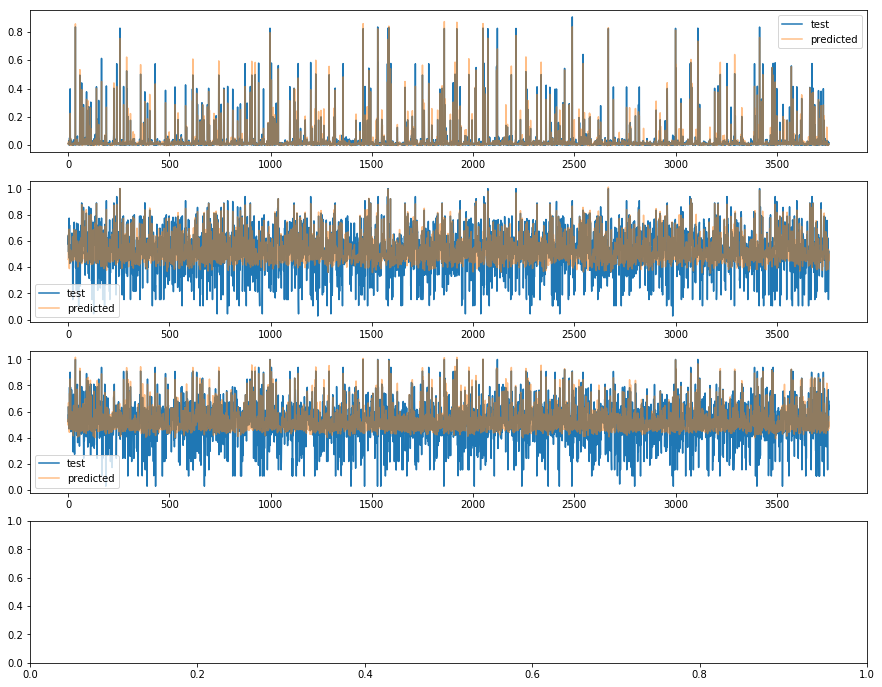

In [62]:
fig, ax = plt.subplots(4,figsize=(15,12))
for i in range(0,3):
    ax[i].plot(y_test[:,i],label = 'test')
    ax[i].plot(y_pr[0][:,i], label = 'predicted',alpha=.5)
    ax[i].legend(loc='best')